# Comparer distance Courte / distance moins bruyant

### Joindre les colonnes de bruit au fichier avec les itinéraires aléatoires 

In [3]:
import sys
sys.path.append("../data_loading")
sys.path.append("../../../script_python")
from data_utils import *
from function_utils import *

sys.path.append("../../../")
from global_variable import *
import os
import geopandas as gpd
import networkx as nx
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import scipy.stats as stats
from pathlib import Path

# Notebook
# from notebook.data_loading.network_loading import load_network_from_gpkg
# from notebook.data_loading.itineraires_loading import load_itineraires_from_csv
# from notebook.data_loading.itineraires_loading import build_graph
# from notebook.data_loading.itineraires_loading import check_required_columns
# from notebook.data_loading.itineraires_loading import check_valid_routes
# from notebook.data_loading.itineraires_loading import compute_all_itineraries
# from notebook.data_loading.itineraires_loading import add_results_to_dataframe
# from notebook.data_loading.itineraires_loading import remove_invalid_routes
# from notebook.data_loading.itineraires_loading import reorder_columns
# from notebook.data_loading.itineraires_loading import save_and_display_results

# from network_loading import load_network_from_gpkg
# from itineraires_loading import load_itineraires_from_csv, build_graph,check_required_columns, check_valid_routes, compute_all_itineraries, add_results_to_dataframe, remove_invalid_routes, reorder_columns, save_and_display_results

# Charger les données 
gpkg_path = globpath("./score_calculation_it/output_data/network/graph/final_network_bruit.gpkg")

# Charger les données du réseau
edges = gpd.read_file(gpkg_path, layer="edges")
nodes = gpd.read_file(gpkg_path, layer="nodes")

# edges, nodes = load_network_from_gpkg(final_network_bruit_path)

# Vérifier que les colonnes nécessaires existent
required_columns = {"u", "v", "score_distance_bruit", "length", "oneway"}
missing_columns = required_columns - set(edges.columns)
if missing_columns:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans le fichier edges : {missing_columns}")

# required_columns = {"u", "v", "total_score_bruit", "length", "oneway"}
# check_required_columns(edges, required_columns)


# Charger le fichier CSV contenant les itinéraires optimisés en distance
itineraire = globpath("./score_calculation_it/notebook/generation_it/itinéraire_court.csv")
itineraire_court_bruit = pd.read_csv(itineraire)

# itineraire_court_bruit = load_itineraires_from_csv(itineraire) 

# Construction du graphe avec les scores de bruit
G_bruit = nx.DiGraph()
for _, row in edges.iterrows():
    G_bruit.add_edge(row['u'], row['v'], weight=row['score_distance_bruit'], length=row['length'])
    if not row['oneway']:
        G_bruit.add_edge(row['v'], row['u'], weight=row['score_distance_bruit'], length=row['length'])

# G_bruit = build_graph(edges, weight_column="score_distance_bruit", length_column="length")


# Vérifier que tous les start_nodes et end_nodes sont bien dans G_bruit
nodes_in_graph = set(G_bruit.nodes)
itineraire_court_bruit = itineraire_court_bruit[
    itineraire_court_bruit["start_node"].isin(nodes_in_graph) & 
    itineraire_court_bruit["end_node"].isin(nodes_in_graph)
]

# itineraire_court_bruit = check_valid_routes(itineraire_court_bruit, G_bruit, "start_node", "end_node")

# Fonction pour calculer l'itinéraire minimisant le bruit
def compute_least_noise_score(start, end):
    """
    Calcule la somme du bruit et la distance totale du chemin minimisant le bruit entre deux nœuds.
    """
    try:
        path = nx.shortest_path(G_bruit, source=start, target=end, weight="weight")
        noise_score = sum(G_bruit[path[i]][path[i+1]]["weight"] for i in range(len(path)-1))
        total_distance = sum(G_bruit[path[i]][path[i+1]]["length"] for i in range(len(path)-1))
        return noise_score, total_distance  # Retourne uniquement le score de bruit et la distance
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan, np.nan  # Aucun chemin trouvé

# results_bruit = compute_all_itineraries(G_bruit, itineraire_court_bruit, "start_node", "end_node", "score_distance_bruit")

# Fonction pour calculer l'itinéraire minimisant la distance
def compute_least_distance_score(start, end):
    """
    Calcule la somme du bruit et la distance totale du chemin minimisant la distance entre deux nœuds.
    """
    try:
        path = nx.shortest_path(G_bruit, source=start, target=end, weight="length")
        total_distance = sum(G_bruit[path[i]][path[i+1]]["length"] for i in range(len(path)-1))
        noise_score = sum(G_bruit[path[i]][path[i+1]]["weight"] for i in range(len(path)-1))
        return total_distance, noise_score
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return np.nan, np.nan  # Aucun chemin trouvé

# results_distance = compute_all_itineraries(G_bruit, itineraire_court_bruit, "start_node", "end_node", "length")


# Exécuter les calculs en parallèle
with ThreadPoolExecutor(max_workers=4) as executor:
    results_bruit = list(executor.map(lambda row: compute_least_noise_score(
        getattr(row, "start_node"), getattr(row, "end_node")), 
        itineraire_court_bruit.itertuples(index=False)
    ))

    results_court = list(executor.map(lambda row: compute_least_distance_score(
        getattr(row, "start_node"), getattr(row, "end_node")), 
        itineraire_court_bruit.itertuples(index=False)
    ))

# Ajouter les résultats au DataFrame
itineraire_court_bruit["bruit_score"], itineraire_court_bruit["distance_bruit"] = zip(*results_bruit)
itineraire_court_bruit["distance_court"], itineraire_court_bruit["bruit_court"] = zip(*results_court)

# itineraire_court_bruit = add_results_to_dataframe(itineraire_court_bruit, results_bruit, "bruit_score", "distance_bruit")

# itineraire_court_bruit = add_results_to_dataframe(itineraire_court_bruit, results_distance, "distance_court", "bruit_court")


# Supprimer les itinéraires où aucun chemin n'a été trouvé
itinéraire_court_bruit = itineraire_court_bruit.dropna(subset=["bruit_score", "distance_bruit", "distance_court", "bruit_court"])

# Supprimer les itinéraires sans solution
# itineraire_court_bruit = remove_invalid_routes(itineraire_court_bruit, ["bruit_score", "distance_bruit", "distance_court", "bruit_court"])


# **Réorganisation des colonnes**
itineraire_court_bruit = itinéraire_court_bruit[["start_node", "end_node", 
                                                "distance_court", "bruit_court", 
                                                "distance_bruit", "bruit_score"]]

# # Réorganiser les colonnes
# itineraire_court_bruit = reorder_columns(itineraire_court_bruit, ["start_node", "end_node", 
#                                                                   "distance_court", "bruit_court", 
#                                                                   "distance_bruit", "bruit_score"])

 # Sauvegarde et affichage des résultats
itineraire_court_bruit.to_csv("itinéraire_court_bruit.csv", index=False)

print(f"\n Calcul terminé : {len(itineraire_court_bruit)} itinéraires enregistrés dans 'itinéraire_court_bruit.csv' !")
print("Colonnes 'distance_court', 'bruit_court', 'distance_bruit', et 'bruit_score' ajoutées et réorganisées avec succès.")


# # Sauvegarder et afficher les résultats
# save_and_display_results(itineraire_court_bruit, "itinéraire_court_bruit.csv")

current_month 3

 Calcul terminé : 1082 itinéraires enregistrés dans 'itinéraire_court_bruit.csv' !
Colonnes 'distance_court', 'bruit_court', 'distance_bruit', et 'bruit_score' ajoutées et réorganisées avec succès.


In [4]:
itineraire_court_bruit

,start_node,end_node,distance_court,bruit_court,distance_bruit,bruit_score
0,3380751025,5657136849,2742.877,14830.554719,2996.964,12667.445890
1,11356942377,171760149,1909.474,21370.489959,1910.025,21107.153922
2,2225197158,4463347218,3511.353,30805.109074,3520.914,30433.281002
3,7603662257,8913559675,875.318,3437.895623,875.318,3437.895623
4,6915264516,373344984,1827.230,19141.294433,2528.801,10762.747240
...,...,...,...,...,...,...
1081,1474023346,2109760437,2821.256,24901.812346,3082.590,24036.769050
1082,1357967486,591898696,3091.884,24388.716915,3229.834,21044.046898
1084,976140519,7356888324,1362.956,10804.815517,1362.956,10804.815517
1085,11197666281,2838044698,3505.793,19292.339962,5212.553,11316.594507


In [5]:
print_statistics(itinéraire_court_bruit, ["distance_court", "distance_bruit"])


Statistiques Descriptives:
       distance_court  distance_bruit
count     1082.000000     1082.000000
mean      2274.243152     2624.759976
std        998.745000     1281.439543
min        600.642000      600.642000
25%       1393.918250     1528.504250
50%       2259.256500     2552.634000
75%       3156.841250     3617.661250
max       4042.968000     8516.575000


# Visualisation

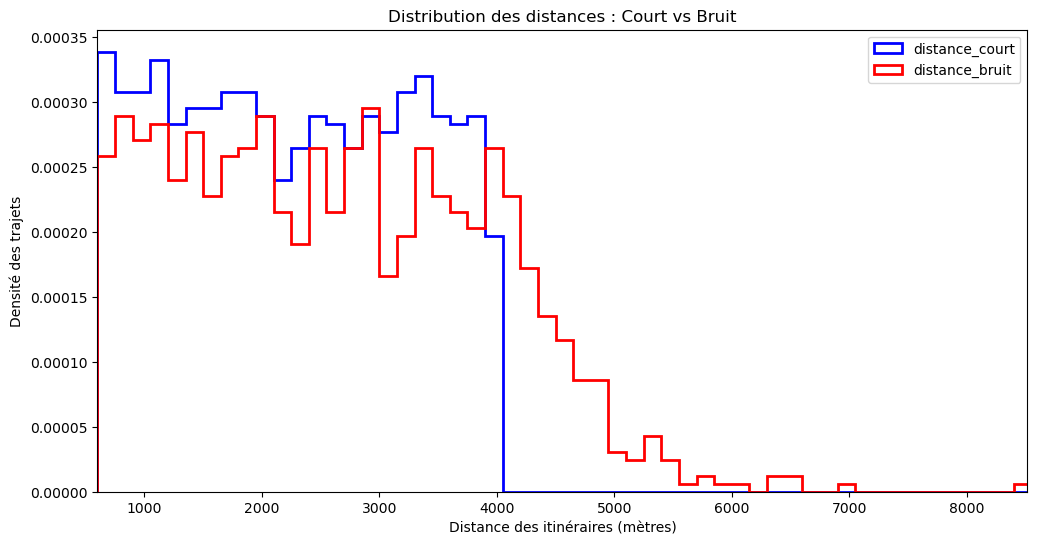

In [6]:
plot_histogram(itinéraire_court_bruit, 
               col_x="distance_court", 
               col_y="distance_bruit", 
               xlabel="Distance des itinéraires (mètres)", 
               ylabel="Densité des trajets", 
               title="Distribution des distances : Court vs Bruit")

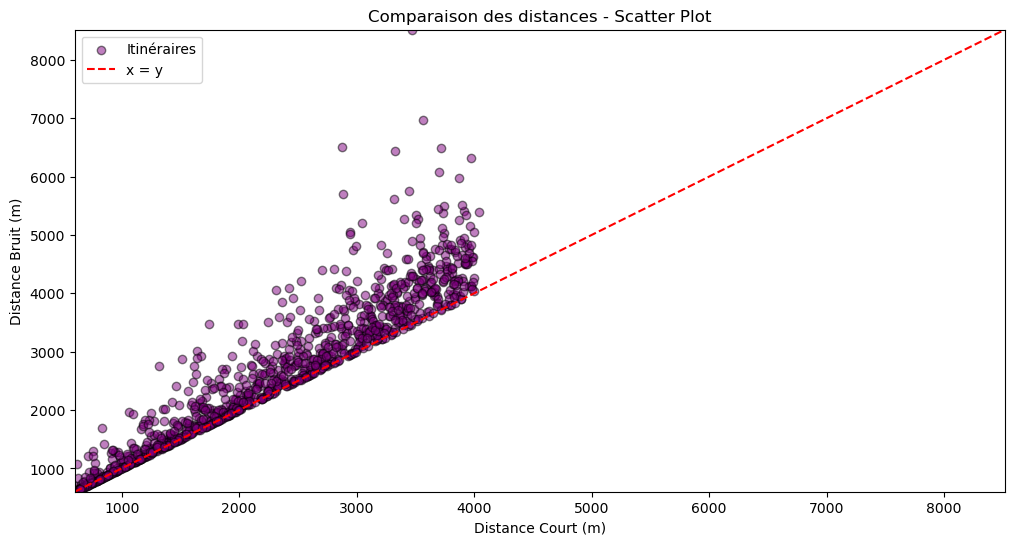

In [7]:
plot_scatter(itinéraire_court_bruit, "distance_court", "distance_bruit", 
             label_x="Distance Court (m)", label_y="Distance Bruit (m)", 
             title="Comparaison des distances - Scatter Plot")


#### Test global 

In [8]:
# Vérifier si `distance_bruit` est globalement plus grande que `distance_court`
moyenne_distance_court = itinéraire_court_bruit["distance_court"].mean()
moyenne_distance_bruit = itinéraire_court_bruit["distance_bruit"].mean()

# Affichage des résultats globaux
global_results = pd.DataFrame({
    "Moyenne Distance Court": [moyenne_distance_court],
    "Moyenne Distance Bruit": [moyenne_distance_bruit],
    "Différence Absolue": [moyenne_distance_bruit - moyenne_distance_court],
    "Différence Relative (%)": [(moyenne_distance_bruit - moyenne_distance_court) / moyenne_distance_court * 100]
})

print("\n COMPARAISON DES DISTANCES ")
print(global_results)


 COMPARAISON DES DISTANCES 
   Moyenne Distance Court  Moyenne Distance Bruit  Différence Absolue  \
0             2274.243152             2624.759976          350.516823   

   Différence Relative (%)  
0                 15.41246  


#### Découpage des données par pas 

In [9]:
# Définition du pas de 300m
step_size = 300

# Définition des bornes min/max avec une marge pour inclure toutes les valeurs
min_distance = itinéraire_court_bruit["distance_court"].min()
max_distance = itinéraire_court_bruit["distance_court"].max()

# Création des intervalles de 148m en s'assurant que max_distance est bien inclus
bins = np.arange(min_distance, max_distance + step_size, step_size)

# Création des groupes avec pd.cut() en forçant l'inclusion des bornes
itinéraire_court_bruit["distance_group"] = pd.cut(
    itinéraire_court_bruit["distance_court"], bins, include_lowest=True
)

# Vérifier la taille des groupes
group_sizes = itinéraire_court_bruit["distance_group"].value_counts().sort_index()
print("\nTAILLE DES GROUPES INITIAUX (PAS 300)")
print(group_sizes)


TAILLE DES GROUPES INITIAUX (PAS 300)
distance_group
(600.6410000000001, 900.642]    105
(900.642, 1200.642]             104
(1200.642, 1500.642]             94
(1500.642, 1800.642]             98
(1800.642, 2100.642]             97
(2100.642, 2400.642]             82
(2400.642, 2700.642]             93
(2700.642, 3000.642]             90
(3000.642, 3300.642]             95
(3300.642, 3600.642]             99
(3600.642, 3900.642]             93
(3900.642, 4200.642]             32
Name: count, dtype: int64


#### Tests de Wilcoxon 

In [10]:
# Initialisation des résultats
results = []

# Calcul des statistiques pour chaque groupe
for group in itinéraire_court_bruit["distance_group"].unique():
    subset = itinéraire_court_bruit[itinéraire_court_bruit["distance_group"] == group]

    # Test de Wilcoxon
    stat, p_value = wilcoxon(subset["distance_bruit"], subset["distance_court"], alternative='greater')

    # Calcul du d de Cohen
    d_value = cohen_d(subset["distance_bruit"], subset["distance_court"])

    # Ajout des résultats dans la liste
    results.append({
        "Intervalle de Distance": group, 
        "Nombre d'Itinéraires": len(subset),
        "Statistique Wilcoxon": stat,
        "p-value": p_value,
        "Cohen's d": d_value
    })

# Création du DataFrame final
distance_bruit_results = pd.DataFrame(results)

# Trier les résultats par ordre croissant de l'intervalle de distance
distance_bruit_results = distance_bruit_results.sort_values(by="Intervalle de Distance", ascending=True)

# Affichage des résultats triés
distance_bruit_results

,Intervalle de Distance,Nombre d'Itinéraires,Statistique Wilcoxon,p-value,Cohen's d
3,"(600.6410000000001, 900.642]",105,1653.0,2.571877e-11,0.421871
8,"(900.642, 1200.642]",104,2485.0,1.779735e-13,0.561128
9,"(1200.642, 1500.642]",94,2346.0,3.820527e-13,0.651140
5,"(1500.642, 1800.642]",98,3240.0,3.924763e-15,0.714014
1,"(1800.642, 2100.642]",97,3403.0,1.831945e-15,0.684280
10,"(2100.642, 2400.642]",82,2775.0,3.866367e-14,0.963249
7,"(2400.642, 2700.642]",93,3321.0,2.681313e-15,0.870112
0,"(2700.642, 3000.642]",90,3655.0,5.845021e-16,0.850783
4,"(3000.642, 3300.642]",95,4371.0,2.785982e-17,1.126247
2,"(3300.642, 3600.642]",99,4656.0,8.906469e-18,0.910723


- Plus la valeur de Statistique Wilcoxon est grande  plus distance_bruit est systématiquement plus grand que distance_court 

- p < seuil alpha la différence entre distance_bruit et distance_court est statistiquement significative

- d de Cohen : Taille de l'effet (Plus la valeur est grande plus la différence entre la distance des chemins courts et la distance des chemins ou on a minimisé le bruit est forte.)

### Question : 

A partir de quelle distance le bruit augmente de manière significative ?

- L’augmentation du bruit commence réellement à partir de 1200 m -> 1500 m, et devient significative après 1500 m.

- À partir de 2700 m, l’effet du bruit est très marqué ce qui signifie que les trajets plus longs sont beaucoup plus bruyants.



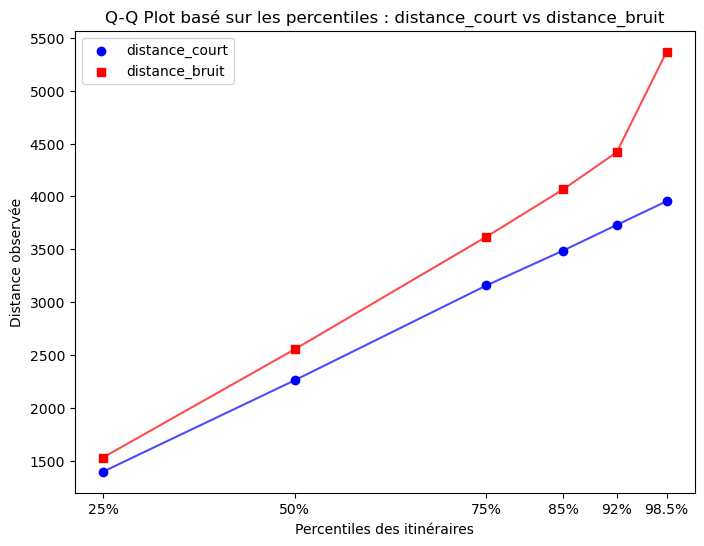

In [11]:
plot_qq(itinéraire_court_bruit, col_court="distance_court", col_score="distance_bruit")

### Questions : 

- Combien d'itinéraires on une augmentation < à 30% 

- Combien d'itinéraires > à 30% 

- Quelle est la fréquence des itinéraires > à 30%

In [12]:
# Définition des quantiles à calculer
quantiles = [0.25, 0.5, 0.75, 0.85, 0.92, 0.985]

# Liste pour stocker les résultats
resultats_list = []


# Calcul de l'augmentation relative de la distance en %
itinéraire_court_bruit["relative_distance_increase"] = (
    (itinéraire_court_bruit["distance_bruit"] - itinéraire_court_bruit["distance_court"]) / 
    itinéraire_court_bruit["distance_court"]
) * 100

# Parcours de chaque groupe d'intervalle
for intervalle in itinéraire_court_bruit["distance_group"].cat.categories:
    # Sélection des données correspondant à l'intervalle
    subset = itinéraire_court_bruit[itinéraire_court_bruit["distance_group"] == intervalle]

    

    # Calcul des quantiles pour l'augmentation relative de la distance
    quantiles_distance = subset["relative_distance_increase"].quantile(quantiles)

    # Calcul de la fréquence des itinéraires > 30% plus longs
    freq_plus_30 = (subset["relative_distance_increase"] > 30).mean() * 100

    # Nombre total de trajets dans cet intervalle
    total_trajets = len(subset)

    # Conversion du pourcentage en nombre d'itinéraires
    nombre_itineraires_sup_30 = int(freq_plus_30 / 100 * total_trajets)

    # Trouver le quantile le plus proche de 30 mais en dessous
    quantiles_below_30 = {f"Q{int(q*100)}": quantiles_distance[q] for q in quantiles if quantiles_distance[q] <= 30}
    quantile_proche_30 = max(quantiles_below_30, key=quantiles_below_30.get) if quantiles_below_30 else None

    # Création d'un dictionnaire avec les résultats
    result_dict = {
        "Intervalle": str(intervalle),  # Convertir en string pour un affichage clair
        "Q25": quantiles_distance[0.25],
        "Q50": quantiles_distance[0.5],
        "Q75": quantiles_distance[0.75],
        "Q85": quantiles_distance[0.85],
        "Q92": quantiles_distance[0.92],
        "Q98.5": quantiles_distance[0.985],
        "Quantile_≤_30": quantile_proche_30,  # Le quantile sous 30%
        "Fréquence_>_30%": freq_plus_30,
        "Nombre_itinéraires_>_30%": nombre_itineraires_sup_30  # Nombre d'itinéraires > 30%
    }

    # Ajouter le dictionnaire à la liste des résultats
    resultats_list.append(result_dict)

# Transformer les résultats en DataFrame final
df_resultats_final = pd.DataFrame(resultats_list)
df_resultats_final = df_resultats_final.round(2)
df_resultats_final

,Intervalle,Q25,Q50,Q75,Q85,Q92,Q98.5,Quantile_≤_30,Fréquence_>_30%,Nombre_itinéraires_>_30%
0,"(600.6410000000001, 900.642]",0.00,0.23,4.40,15.43,29.05,73.00,Q92,8.57,9
1,"(900.642, 1200.642]",0.00,1.28,11.80,22.17,37.60,63.10,Q85,11.54,12
2,"(1200.642, 1500.642]",0.00,5.23,15.25,23.68,42.70,61.47,Q85,12.77,11
3,"(1500.642, 1800.642]",0.84,6.48,20.57,32.24,49.94,86.64,Q75,17.35,17
4,"(1800.642, 2100.642]",0.45,4.35,12.44,24.90,36.37,64.88,Q85,12.37,12
5,"(2100.642, 2400.642]",3.51,10.65,20.84,27.95,35.87,61.62,Q85,13.41,11
6,"(2400.642, 2700.642]",0.98,8.64,21.33,28.55,38.25,63.79,Q85,13.98,12
7,"(2700.642, 3000.642]",2.22,12.43,29.44,36.50,56.88,89.39,Q75,20.00,18
8,"(3000.642, 3300.642]",5.21,10.16,19.54,25.11,33.39,47.81,Q85,10.53,10
9,"(3300.642, 3600.642]",7.04,14.25,24.22,32.38,48.89,94.51,Q75,17.17,16


In [28]:
print(f"Nombre total d'itinéraires ayant une augmentation > 30% : {df_resultats_final["Nombre_itinéraires_>_30%"].sum()}")
print(f"Moyenne des fréquences > 30% : {df_resultats_final["Fréquence_>_30%"].mean()}")

Nombre total d'itinéraires ayant une augmentation > 30% : 144
Moyenne des fréquences > 30% : 13.761666666666668


Interpretaion pour le premier intervalle :

- 92% des trajets ont une augmentation de distance ≤ 29.05%
- 8.57% des trajets dépassent 30% d'augmentation, ce qui représente 9 trajets 


# Comparaison des scores de bruit entre les itinéraires courts et bruyants 

In [15]:
print_statistics(itinéraire_court_bruit, ["bruit_court", "bruit_score"])


Statistiques Descriptives:
        bruit_court   bruit_score
count   1082.000000   1082.000000
mean   17839.095107  14509.832738
std    10746.170400   8744.188162
min     1297.953055   1297.953055
25%     9109.874420   7666.087808
50%    15672.624452  12871.476614
75%    25766.853596  19741.916415
max    59965.871858  59956.044831


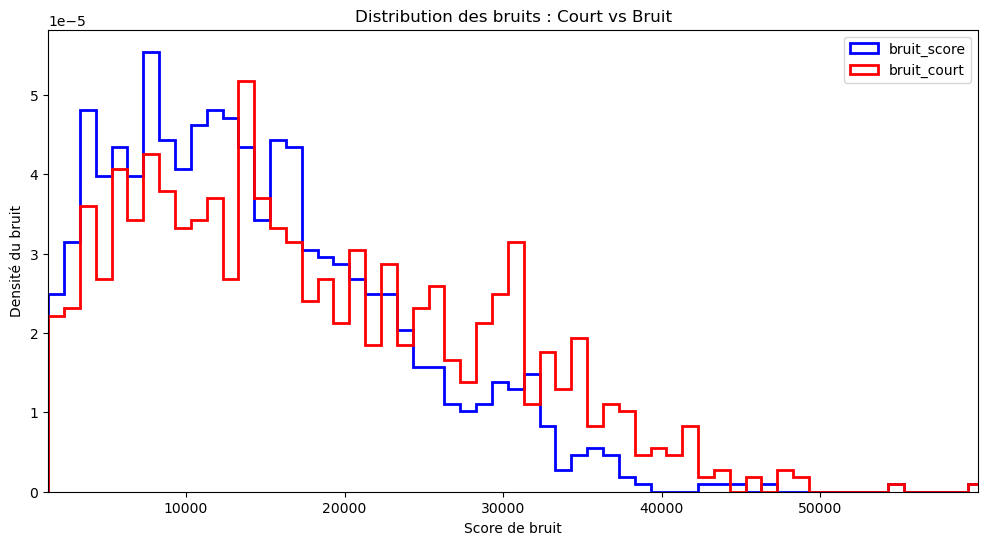

In [16]:
plot_histogram(itinéraire_court_bruit, binwidth= 1000,
               col_x="bruit_score", 
               col_y="bruit_court", 
               xlabel="Score de bruit", 
               ylabel="Densité du bruit", 
               title="Distribution des bruits : Court vs Bruit")


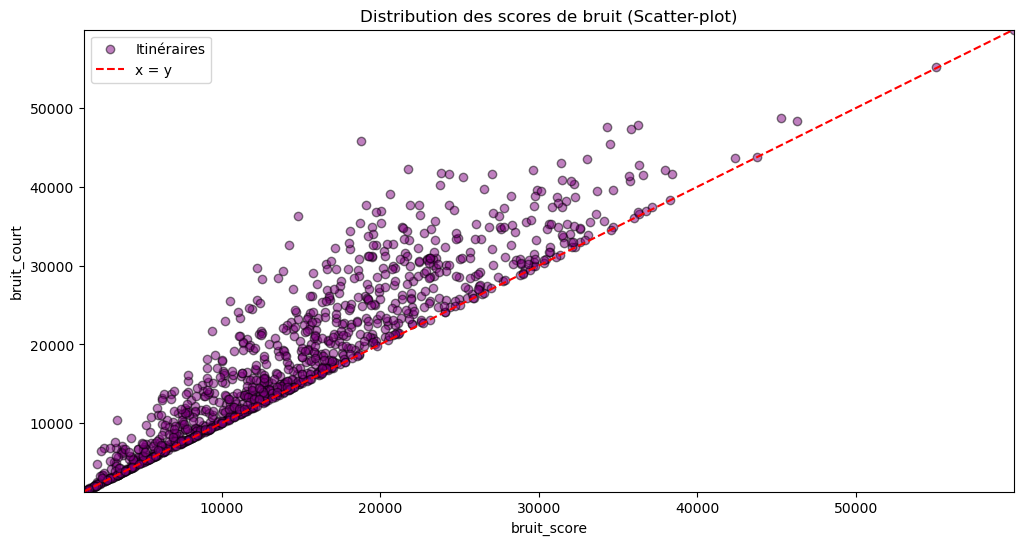

In [17]:
plot_scatter(itinéraire_court_bruit, "bruit_score", "bruit_court", 
         label_x="bruit_score", label_y="bruit_court", 
         title="Distribution des scores de bruit (Scatter-plot)")

In [18]:
# Vérifier si `bruit_court` est globalement plus grande que `bruit_score`
moyenne_bruit_court = itinéraire_court_bruit["bruit_court"].mean()
moyenne_bruit_score = itinéraire_court_bruit["bruit_score"].mean()

# Affichage des résultats globaux
global_results = pd.DataFrame({
    "Moyenne bruit Court": [moyenne_bruit_court],
    "Moyenne bruit Bruit": [moyenne_bruit_score],
    "Différence Absolue": [moyenne_bruit_court-moyenne_bruit_score],
    "Différence Relative (%)": [(moyenne_bruit_court-moyenne_bruit_score) / moyenne_bruit_court * 100]
})

print("\n COMPARAISON DU BRUIT")
print(global_results)


 COMPARAISON DU BRUIT
   Moyenne bruit Court  Moyenne bruit Bruit  Différence Absolue  \
0         17839.095107         14509.832738         3329.262369   

   Différence Relative (%)  
0                18.662731  


In [19]:
# Définition du pas de 300m
step_size = 300

# Définition des bornes min/max avec une marge pour inclure toutes les valeurs
min_distance = itinéraire_court_bruit["distance_court"].min()
max_distance = itinéraire_court_bruit["distance_court"].max()

# Création des intervalles de 148m en s'assurant que max_distance est bien inclus
bins = np.arange(min_distance, max_distance + step_size, step_size)

# Création des groupes avec pd.cut() en forçant l'inclusion des bornes
itinéraire_court_bruit["distance_group"] = pd.cut(
    itinéraire_court_bruit["distance_court"], bins, include_lowest=True
)

# Vérifier la taille des groupes
group_sizes = itinéraire_court_bruit["distance_group"].value_counts().sort_index()
print("\nTAILLE DES GROUPES INITIAUX (PAS 300)")
print(group_sizes)


TAILLE DES GROUPES INITIAUX (PAS 300)
distance_group
(600.6410000000001, 900.642]    105
(900.642, 1200.642]             104
(1200.642, 1500.642]             94
(1500.642, 1800.642]             98
(1800.642, 2100.642]             97
(2100.642, 2400.642]             82
(2400.642, 2700.642]             93
(2700.642, 3000.642]             90
(3000.642, 3300.642]             95
(3300.642, 3600.642]             99
(3600.642, 3900.642]             93
(3900.642, 4200.642]             32
Name: count, dtype: int64


In [20]:
# Initialisation des résultats pour Wilcoxon
results = []

# Calcul des statistiques pour chaque groupe (bruit_court vs bruit_score)
for group in itinéraire_court_bruit["distance_group"].unique():
    subset = itinéraire_court_bruit[itinéraire_court_bruit["distance_group"] == group]

    # Test de Wilcoxon pour vérifier si bruit_score est inférieur à bruit_court
    stat, p_value = wilcoxon(subset["bruit_score"], subset["bruit_court"], alternative='less')

    # Calcul du d de Cohen
    mean_diff = subset["bruit_court"].mean() - subset["bruit_score"].mean()
    pooled_std = np.sqrt((subset["bruit_court"].std() ** 2 + subset["bruit_score"].std() ** 2) / 2)
    d_value = mean_diff / pooled_std if pooled_std > 0 else np.nan  # Éviter la division par zéro

    # Ajout des résultats dans la liste
    results.append({
        "Intervalle de Distance": group,
        "Nombre d'Itinéraires": len(subset),
        "Statistique Wilcoxon": stat,
        "p-value": p_value,
        "Cohen's d": d_value
    })

# Création du DataFrame final avec les résultats
bruit_results = pd.DataFrame(results)

# Trier les résultats par ordre croissant de l'intervalle de distance
bruit_results = bruit_results.sort_values(by="Intervalle de Distance", ascending=True)
bruit_results

,Intervalle de Distance,Nombre d'Itinéraires,Statistique Wilcoxon,p-value,Cohen's d
3,"(600.6410000000001, 900.642]",105,0.0,2.571877e-11,0.188732
8,"(900.642, 1200.642]",104,0.0,1.779735e-13,0.246780
9,"(1200.642, 1500.642]",94,0.0,3.820527e-13,0.290684
5,"(1500.642, 1800.642]",98,0.0,3.924763e-15,0.404755
1,"(1800.642, 2100.642]",97,0.0,1.831945e-15,0.331292
10,"(2100.642, 2400.642]",82,0.0,3.866367e-14,0.645682
7,"(2400.642, 2700.642]",93,0.0,2.681313e-15,0.508748
0,"(2700.642, 3000.642]",90,0.0,5.845021e-16,0.561894
4,"(3000.642, 3300.642]",95,0.0,2.785982e-17,0.743457
2,"(3300.642, 3600.642]",99,0.0,8.906469e-18,0.754646


#### Stat Wilcoxon :
Plus la valeur est grande plus le bruit des chemins courts est supérieur à celui des chemins ou on a minimisé le bruit, donc plus l’optimisation du bruit est efficace

#### P_Value : 

Plus la valeur est faible plus la réduction du bruit est statistiquement significative (5%)

#### Cohen : 

Plus la valeur est grande plus la différence entre le bruit des chemins courts et le bruit des chemins ou on a minimisé le bruit est forte. Un grand effet indique une forte réduction du bruit.

## A partir de 2100m commence vraiment à augmenter (Modéré -> Fort), leffet de la distance devient plus fort au dela de 2100 m.

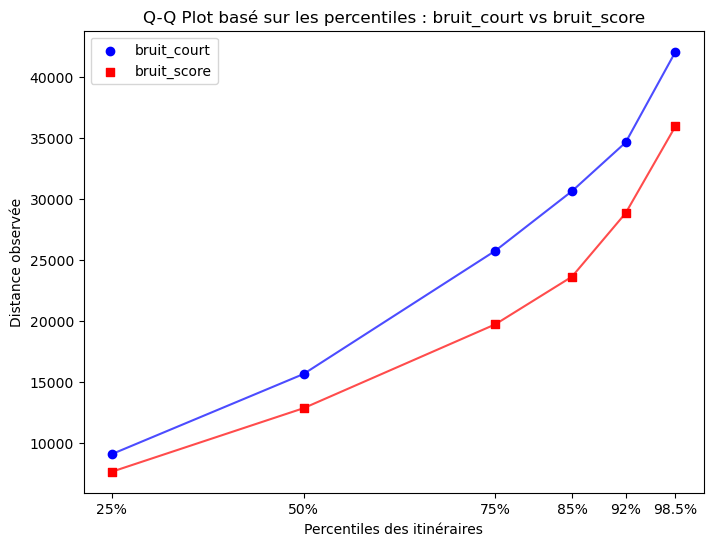

In [21]:
plot_qq(itinéraire_court_bruit, col_court="bruit_court", col_score="bruit_score")

## Mesure la réduction du bruit 

(bruit_court - bruit_score)

Question : Pour chaque intervalle quelle est la réduction moyenne du bruit en % ?

In [22]:
# Définition des quantiles à calculer
quantiles = [0.25, 0.5, 0.75, 0.85, 0.92, 0.985]

# Liste pour stocker les résultats
resultats_bruit = []

# Parcours de chaque groupe d'intervalle
for intervalle in itinéraire_court_bruit["distance_group"].cat.categories:
    # Sélection des données correspondant à l'intervalle
    subset = itinéraire_court_bruit[itinéraire_court_bruit["distance_group"] == intervalle].copy()

    # Calcul de la réduction du bruit (absolue)
    subset.loc[:, "réduction_bruit"] = subset["bruit_court"] - subset["bruit_score"]

    # Calcul de la réduction du bruit en pourcentage
    subset.loc[:, "réduction_bruit_%"] = (subset["réduction_bruit"] / subset["bruit_court"]) * 100

    # Calcul du gain par mètre (réduction du bruit divisée par la distance de l'itinéraire court)
    subset.loc[:, "gain_par_mètre"] = subset["réduction_bruit"] / subset["distance_court"]

    # Calcul des quantiles pour la réduction du bruit et le gain par mètre
    quantiles_bruit_pct = subset["réduction_bruit_%"].quantile(quantiles)
    quantiles_gain_m = subset["gain_par_mètre"].quantile(quantiles)

    # Calcul de la moyenne de la réduction du bruit et du gain par mètre
    moyenne_réduction_bruit_pct = subset["réduction_bruit_%"].mean()
    moyenne_gain_par_mètre = subset["gain_par_mètre"].mean() # Peut etre en % ?

    # Création d'un dictionnaire avec les résultats
    result_dict = {
        "Intervalle": str(intervalle),  
        "Q25 (Bruit %)": quantiles_bruit_pct[0.25],
        "Q50 (Bruit %)": quantiles_bruit_pct[0.5],
        "Q75 (Bruit %)": quantiles_bruit_pct[0.75],
        "Q85 (Bruit %)": quantiles_bruit_pct[0.85],
        "Q92 (Bruit %)": quantiles_bruit_pct[0.92],
        "Q98.5 (Bruit %)": quantiles_bruit_pct[0.985],
        "Moyenne Réduction Bruit %": moyenne_réduction_bruit_pct,
        "Moyenne Gain par mètre": moyenne_gain_par_mètre
    }

    # Ajouter le dictionnaire à la liste des résultats
    resultats_bruit.append(result_dict)

# Transformer les résultats en DataFrame final
df_resultats_bruit = pd.DataFrame(resultats_bruit)
df_resultats_bruit = df_resultats_bruit.round(2)  
df_resultats_bruit


,Intervalle,Q25 (Bruit %),Q50 (Bruit %),Q75 (Bruit %),Q85 (Bruit %),Q92 (Bruit %),Q98.5 (Bruit %),Moyenne Réduction Bruit %,Moyenne Gain par mètre
0,"(600.6410000000001, 900.642]",0.00,0.23,9.52,16.71,29.70,51.51,7.57,0.68
1,"(900.642, 1200.642]",0.00,2.65,18.51,29.33,41.55,59.10,11.70,0.83
2,"(1200.642, 1500.642]",0.00,3.86,22.53,27.27,39.63,51.67,11.88,0.94
3,"(1500.642, 1800.642]",1.14,8.05,22.83,30.56,35.95,47.61,13.26,1.07
4,"(1800.642, 2100.642]",1.05,7.13,17.18,25.69,36.47,43.86,11.85,0.93
5,"(2100.642, 2400.642]",5.05,16.50,27.22,37.54,47.91,55.00,19.18,1.43
6,"(2400.642, 2700.642]",2.53,12.19,31.53,37.21,41.94,51.95,17.02,1.45
7,"(2700.642, 3000.642]",3.23,14.88,25.77,32.19,37.93,47.35,16.48,1.44
8,"(3000.642, 3300.642]",6.38,18.92,33.20,36.71,42.77,54.19,20.57,1.74
9,"(3300.642, 3600.642]",10.02,21.21,34.63,39.53,42.12,49.56,22.13,1.82


## Il y a une tendance d'augmentation de la réduction du bruit avec la distance, avec un effet plus fort sur les longues distances (3000, ...)
## Amélioration significative du gain par mètre à partir de 2100m 

Interpretation pour la première intervalle : 

- 50% des itinéraires ont une réduction de bruit de 0.23% ou moins (Pratiquement aucune réduction significative du bruit)

- 98.5% des itinéraires ont une réduction de bruit inférieure à 51%.
 
- En moyenne les itinéraires réduisent le bruit de 7%

- En moyenne les itinéraires on un gain de 0.68 par mètre